# Вводная

В рамках прохождения курса по математики, темы Линейной алгебры, был очень впечатлен таким простым / не простым методом как матричная факторизация. В курсе давался массив данных 20 на 30, и на нем показывался метод. Прикольно. Но захотелось чего-то большего. Захотелось своими руками воспроизвести все этапы, от сбора данных, до получения резульатов самой модели.

Интересный факт.  
В 2006 году Netflix, в ходе улучшений своих рекомендательных систем, нашла новый подход, основанный на матричной факторизации. На самом деле методу было уже пара веков, но Netflix смогла его применить к бизнес задаче, заработать много тысяч денег, и стать теми кем мы все их знаем. В истории даже остался термин Netflix Matrix Factorization *(Матричная факторизация Нетфликса)*.

В общем захотелось посмотреть что это такое. Данные парсил с КиноПоиска. Собрал данные по 300 пользователям, 16000 фильмам. Получилось ~130.000 оценок.  

Честно скажу, показатели можно выкрутить еще сильнее, модель можно улучшать и оптимизировать. Направлений много. В проекте оставил те, что дали лучший результат.

# Описание

В данном проекте будем исследовать подход к построению рекомендательной системы с использованием метода матричной факторизации.  

Наши данные включают оценки пользователей для различных фильмов, что позволит нам предсказать будущие предпочтения пользователей.

# Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/kaggle/input/data-kp/data_kp_total.csv',index_col=0)

df.head()

,user_name,movie_ru,movie_en,category,time_movie,movie_year,rating,number_voters,vote,date
user_id,,,,,,,,,,
1948983,SVanG,"Дороро (сериал, 2019)",Dororo,сериал,24.0,2019,8.305,74708,8,2024-01-05 18:00:00
1948983,SVanG,Форсаж 8 (2017),The Fate of the Furious,фильм,136.0,2017,6.232,217114,5,2024-01-05 17:58:00
1948983,SVanG,Князь тьмы (1987),Prince of Darkness,фильм,102.0,1987,6.209,5837,6,2024-01-05 17:57:00
1948983,SVanG,В пасти безумия (1994),In the Mouth of Madness,фильм,91.0,1994,6.964,19868,6,2024-01-05 17:57:00
1948983,SVanG,"Секретное вторжение (мини-сериал, 2023)",Secret Invasion,сериал,47.0,2023,5.281,13734,2,2024-01-05 17:53:00


In [3]:
df.shape

(131213, 10)

In [4]:
df.rename(columns={'number_voters': 'number_ratings'}, inplace=True)

In [5]:
df.columns

Index(['user_name', 'movie_ru', 'movie_en', 'category', 'time_movie',
       'movie_year', 'rating', 'number_ratings', 'vote', 'date'],
      dtype='object')

In [6]:
df = df[['user_name', 'movie_ru', 'movie_year', 'time_movie',  'rating', 'number_ratings', 'vote', 'date']]
df = df.reset_index(drop=True)
df.tail()

,user_name,movie_ru,movie_year,time_movie,rating,number_ratings,vote,date
131208,SeriDC,Мстители: Эра Альтрона (2015),2015,141.0,7.258,439556,7,2015-10-26 21:42:00
131209,SeriDC,Нечто (1982),1982,109.0,7.925,140679,8,2015-10-26 10:08:00
131210,SeriDC,Космос: Территория смерти (2008),2008,74.0,6.758,9350,7,2015-10-26 00:35:00
131211,SeriDC,Зелёный слоник (1999),1999,86.0,5.594,103738,9,2015-10-25 22:33:00
131212,SeriDC,500 дней лета (2009),2009,95.0,7.640,264980,8,2015-10-17 18:43:00


- `rating` -  рейтинг фильма на КиноПоиске
- `number_ratings` -  количество проголосовавших за этот рейтинг
- `vote` -  оценка пользователя

# Предобработка

In [7]:
# количество дублей
df.duplicated().sum()

0

In [8]:
df.duplicated(['user_name','movie_ru']).sum()

0

In [9]:
# количество пропусков
df.isna().sum()

user_name           0
movie_ru            0
movie_year          0
time_movie        252
rating              0
number_ratings      0
vote                0
date                0
dtype: int64

In [10]:
# поправляем индексы
df = df.reset_index(drop=True)
df

,user_name,movie_ru,movie_year,time_movie,rating,number_ratings,vote,date
0,SVanG,"Дороро (сериал, 2019)",2019,24.0,8.305,74708,8,2024-01-05 18:00:00
1,SVanG,Форсаж 8 (2017),2017,136.0,6.232,217114,5,2024-01-05 17:58:00
2,SVanG,Князь тьмы (1987),1987,102.0,6.209,5837,6,2024-01-05 17:57:00
3,SVanG,В пасти безумия (1994),1994,91.0,6.964,19868,6,2024-01-05 17:57:00
4,SVanG,"Секретное вторжение (мини-сериал, 2023)",2023,47.0,5.281,13734,2,2024-01-05 17:53:00
...,...,...,...,...,...,...,...,...
131208,SeriDC,Мстители: Эра Альтрона (2015),2015,141.0,7.258,439556,7,2015-10-26 21:42:00
131209,SeriDC,Нечто (1982),1982,109.0,7.925,140679,8,2015-10-26 10:08:00
131210,SeriDC,Космос: Территория смерти (2008),2008,74.0,6.758,9350,7,2015-10-26 00:35:00
131211,SeriDC,Зелёный слоник (1999),1999,86.0,5.594,103738,9,2015-10-25 22:33:00


In [11]:
# распределение по оценкам
df['vote'].value_counts()

vote
7     36726
8     30643
6     22916
9     12799
5     11375
10     7302
4      4443
3      2260
1      1519
2      1230
Name: count, dtype: int64

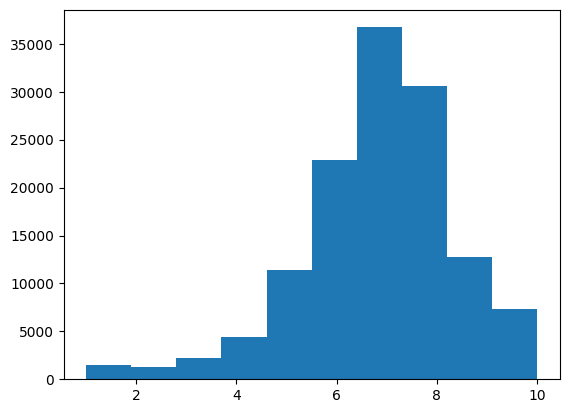

In [12]:
plt.hist(df['vote'],bins=10)
plt.show()

- единиц больше чем двоек, это не естественно для нормального распределения

In [13]:
# оценки равные 1
df.query('vote == 1')

,user_name,movie_ru,movie_year,time_movie,rating,number_ratings,vote,date
458,SVanG,7 главных желаний (2013),2013,80.0,1.572,7482,1,2021-10-19 16:34:00
542,SVanG,Что творят мужчины! (2013),2013,83.0,3.321,48360,1,2020-12-20 10:40:00
547,SVanG,Кавказская пленница! (2014),2014,95.0,1.112,62904,1,2020-12-20 10:38:00
1124,SVanG,Терминатор: Генезис (2015),2015,126.0,6.425,171994,1,2019-11-08 18:09:00
1125,SVanG,Терминатор: Тёмные судьбы (2019),2019,128.0,5.784,195299,1,2019-11-08 18:08:00
...,...,...,...,...,...,...,...,...
130887,SergeTSG89,Вратарь Галактики (2020),2020,115.0,4.933,109155,1,2020-10-12 00:22:00
130915,SergeTSG89,Газгольдер. Клубаре (2018),2018,108.0,4.303,17007,1,2019-02-16 03:19:00
130936,SergeTSG89,Крымский мост. Сделано с любовью! (2018),2018,102.0,2.890,52718,1,2018-11-07 13:24:00
130942,SergeTSG89,Звёздные войны: Последние джедаи (2017),2017,152.0,6.654,200278,1,2018-03-13 17:34:00


- скорее всего единицы ставят чтобы выразить негодование, и чтобы намеренно опустить общую оценку фильма вниз  
- такие оценки не оценивают фильм, а скорее выражают позицию
  

- чтобы не путать модель, уберем единицы из набора

In [14]:
# удалим самые низкие оценки
df = df.query('vote != 1')
df.shape[0]

129694

In [15]:
# посчитаем сколько фильмов получили по сколько оценок
bar = df['movie_ru'].value_counts()
bar[:15]

movie_ru
Дюна (2021)                                        138
Бегущий по лезвию 2049 (2017)                      127
Джокер (2019)                                      126
Достать ножи (2019)                                123
Паразиты (2019)                                    123
Джентльмены (2019)                                 122
Довод (2020)                                       122
Драйв (2011)                                       120
Всё везде и сразу (2021)                           114
Прибытие (2016)                                    113
Бегущий по лезвию (1982)                           112
Человек-паук: Нет пути домой (2021)                112
Однажды в… Голливуде (2019)                        112
Залечь на дно в Брюгге (2007)                      111
Три билборда на границе Эббинга, Миссури (2017)    111
Name: count, dtype: int64

In [16]:
# посчитаем количества по количеству оценок у фильмов
# сколько фильмов имеет по сколько оценок
bar = df['movie_ru'].value_counts().reset_index().rename(columns={'count': 'number_votes'})
bar['number_votes'].value_counts().reset_index().rename(columns={'count': 'number_movies'})

,number_votes,number_movies
0,1,6468
1,2,2238
2,3,1287
3,4,840
4,5,552
...,...,...
111,103,1
112,102,1
113,101,1
114,100,1


- `number_votes` - количество оценок
- `number_movies` - количество фильмов
- 6468 фильмов имеют всего одну оценку
- фильмы оцененные только двумя пользователями - 2238
- самый оцененный фильм в нашем наборе имеет 138 оценок - **"Дюна"** 2021 года


---

Для будущей передсказательной модели необходимо чтобы объекты (фильмы) имели какое-то минимальное количество наблюдений (оценок)  

Уберем из набора фильмы с низким количеством оценок

In [17]:
# установим минимальное количество оценок
min_vote = 5

In [18]:
# фильмы с малым количеством оценок
(df['movie_ru'].value_counts().reset_index()).query('count <= @min_vote')

,movie_ru,count
4495,Плёнки из Поукипзи (2006),5
4496,Робин Гуд: Принц воров (1991),5
4497,Календарь дьявола (2020),5
4498,Прошлые жизни (2023),5
4499,Банда Келли (2003),5
...,...,...
15875,"Привет, Скуби-Ду (2005)",1
15876,"Отдыхай, Скуби-Ду! (2006)",1
15877,Скуби-Ду! Искусство борьбы (2014),1
15878,Скуби-Ду! и нашествие инопланетян (2000),1


In [19]:
# создаем список фильмов с малым количеством оценок
movie_del = list((df['movie_ru'].value_counts().reset_index()).query('count <= @min_vote')['movie_ru'])
movie_del[:10]

['Плёнки из Поукипзи (2006)',
 'Робин Гуд: Принц воров (1991)',
 'Календарь дьявола (2020)',
 'Прошлые жизни (2023)',
 'Банда Келли (2003)',
 'Дикий ангел (сериал, 1998 – 1999)',
 'Где бы ты ни был (2011)',
 'Психопаспорт (сериал, 2012 – 2019)',
 'Самый главный босс (2006)',
 'Синьор Робинзон (1976)']

In [20]:
# размер списка
len(set(movie_del))

11385

In [21]:
# вырезаем из массива все фильмы с малым количеством оценок
df = df.query('movie_ru not in @movie_del')
df.shape

(108769, 8)

---

In [22]:
# количество уникальных фильмов
df['movie_ru'].nunique()

4495

In [23]:
# количество юзеров
df['user_name'].nunique()

309

In [24]:
# общее количество оценок
df.shape[0]

108769

In [25]:
# уровень разряженности полной матрицы
df.shape[0] / (df['movie_ru'].nunique() * df['user_name'].nunique())

0.07830995244626356

# Делим данные на test / train

In [26]:
train, test = train_test_split(df, test_size=0.1, random_state=42)
print(f'train: {len(train)}')
print(f'test:  {len(test)}')

train: 97892
test:  10877


In [27]:
train.shape

(97892, 8)

In [28]:
test.shape

(10877, 8)

# Собираем модель

In [29]:
# пересоберем наш тренеровочный набор в сводную таблицу
# по строкам будут пользователи, по колонкам фильмы, в значениях оценки
pivot = train.pivot_table(columns='movie_ru', index='user_name', values='vote')
pivot

movie_ru,...А зори здесь тихие (1972),007: Координаты «Скайфолл» (2012),007: СПЕКТР (2015),1+1 (2011),10 000 лет до н.э. (2008),10 причин моей ненависти (1999),100 вещей и ничего лишнего (2018),101 далматинец (1961),101 далматинец (1996),"11.22.63 (мини-сериал, 2016)",...,"Я, снова я и Ирэн (2000)",Явление (2008),Яма (2001),Ямакаси: Свобода в движении (2001),Яркость (2017),Ярость (2008),Ярость (2014),"вДудь (сериал, 2017 – ...)",мама! (2017),…А в душе я танцую (2004)
user_name,,,,,,,,,,,,,,,,,,,,,
+79631420786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
--max--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN
-Radical,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-casta-,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN
11igor1991@mail.ru,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Константин Васькин,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN
Максим Антонкин,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Мелисандра,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN


In [30]:
# заменим пустые значения нулями
pivot = pivot.fillna(0)

In [31]:
# преобразуем сводную таблицу в матрицу рейтингов - R
R = np.array(pivot)
R

array([[ 0.,  0.,  0., ...,  0.,  5.,  0.],
       [ 0.,  0.,  0., ...,  0.,  8.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  9.,  0.],
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  7.,  0.]])

In [32]:
R.shape

(309, 4495)

 - **R - матрица рейтингов**  
Это матрица, где строки соответствуют пользователям, а столбцы – фильмам. Каждое значение в матрице представляет собой рейтинг, который пользователь поставил конкретному фильму. Если пользователь не оценил фильм, то соответствующая ячейка остается пустой.
 - **R_binary - Бинарная матрица**  
Это матрица с такой же структурой, как и матрица рейтингов `R`, но вместо реальных значений рейтингов содержит бинарные значения. True указывает на то что пользователь оценил фильм, а False – что не оценил

In [33]:
# создаем бинарную матрицу для отслеживания ненулевых рейтингов
R_binary = R > 0
R_binary

array([[False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False]])



 - **K - количество скрытых факторов**  
Это параметр, который определяет количество скрытых факторов, используемых для матричной факторизации. Скрытые факторы представляют собой абстрактные характеристики, которые могут объяснить предпочтения пользователей и свойства фильмов.  

- **P - матрица пользователь-фактор**  
Это матрица размером 𝑚 × K, где 𝑚 – количество пользователей, а K – количество скрытых факторов. Каждая строка в матрице P представляет собой вектор скрытых факторов для одного пользователя. Эти векторы описывают предпочтения пользователей в терминах скрытых факторов.  
  
- **Q - матрица фактор-элемент**  
Это матрица размером 𝑛 × K, где 𝑛 – количество фильмов, а K – количество скрытых факторов. Каждая строка в матрице Q представляет собой вектор скрытых факторов для одного фильма. Эти векторы описывают свойства фильмов в терминах скрытых факторов.

In [34]:
# количество скрытых факторов
K = 80

# инициализизуем матрицы пользователь-фактор и фактор-элемент случайными значениями
P = np.random.rand(R.shape[0], K)
Q = np.random.rand(K, R.shape[1])

print('P:', P.shape)
print('Q:', Q.shape)

P: (309, 80)
Q: (80, 4495)


---

**Матричная факторизация**  
Основная идея заключается в разложении исходной матрицы рейтингов R на две матрицы меньшей размерности P и Q так, чтобы их произведение приближало исходную матрицу R.  
  
Для нахождения оптимальных значений матриц P и Q будем использовать метод градиентного спуска

In [ ]:
steps = 400      # количество шагов для обучения
lr = 0.001       # скорость обучения
lambda_ = 0.015  # параметр регуляризации

tolerance = 1e-6        # порог терпимости для критерия остановки
previous_loss = np.inf  # предустановленная ошибка - бесконечность

for step in range(steps):
    for k in range(K):
        # обновляем P и Q с использованием векторизации, для P[:, k] и Q[k, :]
        P[:, k] += lr * ((R - np.dot(P, Q)) * R_binary).dot(Q[k, :].T) - lambda_ * P[:, k]
        Q[k, :] += lr * ((R - np.dot(P, Q)) * R_binary).T.dot(P[:, k]) - lambda_ * Q[k, :]

    # расчет среднеквадратической ошибки loss (метод MSE)
    squared_error = (R_binary * (R - np.dot(P, Q)))**2
    loss = np.sum(squared_error) / np.count_nonzero(R_binary)

    # вывод прогресса каждые 10 шагов
    if (step + 1) % 10 == 0:
        print(f"Step {step + 1}, loss: {loss.round(5)}")

    # остановка, если разница в ошибке меньше заданного порога
    if np.abs(previous_loss - loss) < tolerance:
        break

    previous_loss = loss

Step 10, loss: 1.27711
Step 20, loss: 1.08717


In [ ]:
print("Предсказанная матрица:")
print((P @ Q).round(1)[:10,:10])
print("\nОригенальная матрица:")
print(R[:10,:10])

In [ ]:
# создаем переменную approx - матрицу предсказаний
approx = P @ Q

In [ ]:
# заменяем в предсказанной матрице известные рейтинги из исходной матрицы
approx[R_binary] = R[R_binary]
approx.round(1)[:10,:10]

In [ ]:
# пересобераем approx в DataFrame model, с названиями фильмов и user_name
model = pd.DataFrame(columns=pivot.columns, index=pivot.index, data=approx)
model

- `model` - это наша предсказательная модель
- это таблица с пользователями в строках, и фильмами в столбцах
- в значениях стоят предсказанные оценки по всем фильмам
- кроме тех случаев, когда пользователь ставил оценку
- оценку можно заметить, числа с 6 нулями после точки

# Оценка модели

In [ ]:
# преобразуем model в вертикальную таблицу
model_long = model.reset_index().melt(id_vars=['user_name'], var_name='movie_ru', value_name='vote_predict')
model_long.rename(columns={'index': 'user_name'}, inplace=True)
model_long

- теперь `model` представлена в виде в вертикальной таблицы `model_long`
- каждому пользователю, на каждый фильм предсказана оценка `vote_predict`
- всего 1.388.955 оценок

In [ ]:
# выведем тренировочные данные
train_users = train['user_name'].nunique()
train_movies = train['movie_ru'].nunique()
train_votes = train.shape[0]
sparse_matrix = train_votes / model_long.shape[0]

print('ТРЕНИРОВОЧНЫЕ ДАННЫЕ: \n')
print(f'train_users:    {train_users}')
print(f'train_movies:   {train_movies}')
print(f'train_votes:    {train_votes}')
print(f'sparse_matrix:  {round(sparse_matrix,3)}')

In [ ]:
# чтобы оценить результат, объединаяем model_long с test
res = test.merge(model_long, on=['user_name', 'movie_ru'], how='inner')
result = res[['user_name','movie_ru','rating','vote_predict','vote']].copy()
result

- мы объеденили тестовую выборку `test` с нашей `model_long` по inner пересечению, по `'user_name'`, `'movie_ru'` колонкам
- получаем таблицу `result` :
 - колонка `rating` - рейтинг на КиноПоиске
 - колонка `vote_predict` - предсказанная оенка модели
 - колонка `vote` - оценки пользователей, на которых модель не обучалась

In [ ]:
# считаем тестовые характеристики
users = result['user_name'].nunique()
movies = result['movie_ru'].nunique()
votes = result.shape[0]

print('ТЕСТОВАЯ ВЫБОРКА:\n')
print(f'Пользователей:      {users}')
print(f'Уникальных фильмов: {movies}')
print(f'Голосов:            {votes}')

In [ ]:
# считаем квадратичную ошибку оценки vote, по рейтингу и предсказанной оценке
result['squer_error_rating'] = (result['rating'] - result['vote'])**2
result['squer_error_predict'] = (result['vote_predict'] - result['vote'])**2
result

In [ ]:
# считаем rmse по рейтингу и предсказанию
# объединяем все ошибки, делим на их количество, берем корень
rmse_rating = np.sqrt( sum(result['squer_error_rating'])  / result.shape[0])
rmse_predict = np.sqrt( sum(result['squer_error_predict'])  / result.shape[0])

In [ ]:
print('TRAIN')
print(f'  users:          {train_users}')
print(f'  movies:         {train_movies}')
print(f'  votes:          {train_votes}')
print(f'  sparse_matrix:  {round(sparse_matrix,3)}')
print('TEST')
print(f'  users:          {users}')
print(f'  movies:         {movies}')
print(f'  votes:          {votes}')
print('INFO')
print(f'  K:              {K}')
print(f'  steps:          {steps}')
print(f'  lr:             {lr}')
print(f'  lambda:         {lambda_}')
print(f'  loss_model:     {round(loss,4)}')
print(f'  rmse_rating:    {round(rmse_rating,4)}')
print(f'  rmse_predict:   {round(rmse_predict,4)}')

# Краткий пересказ проекта

- Все данные парсились с КиноПоиска, и собраны в файле `data_kp_total.csv`  

- В ходе обработки данных были исключены все оценки равные единицы  
- Были исключены все фильмы у которых было менее 5 оценок

- Все необходимые данные были собраны в переменной `df`
- В итоге вышло 309 пользователя, и 4495 уникальных фильма

- Данные были разделены на `train` и `test` выборки, в соотношение 1/9
- В тестовой выборке 10877 оценок
- В тренеровочной 97892 оценок

- Тренировочные данные были трансформированы в сводную таблицу `pivot`, где:
 - строки – это пользователи
 - столбцы – это фильмы
 - значения – это оценки фильмам

- На основе сводной таблицы была создана матрица рейтингов `R`
- Уровень разряженности матрицы `R` составил - 0.07%

- Была создана бинарная матрица `R_binary`, оценивал ли пользователь фильм (True) или нет (False)
- Количество скрытых факторов `K` было установлено равным 80
- Матрица пользователь-фактор `P` и матрица фактор-элемент `Q` инициализированы случайными значениями

- Для построения предсказательной модели применяем **матричную факторизацию**
- Основная идея которой заключается в разложении исходной матрицы рейтингов `R` на две матрицы меньшей размерности `P` и `Q` так, чтобы их произведение приближало исходную матрицу `R`
- Для нахождения оптимальных значений матриц `P` и `Q` использовали метод градиентного спуска

- Обучение модели:
  - Количество шагов для обучения `steps` установлено – 400
  - Скорость обучения `lr` – 0.001
  - Параметр регуляризации `lambda_` был задан – 0.015


- В качестве оценки качества модели был выбран критерий MSE - средне квадратичная ошибка
- Входе обучения ошибка дошла до 0.54

- Получили матрицу предсказаний `approx`
- Заменили в `approx` оценки, которые были в исходной матрицы, используя `R_binary`
- Матрицу предсказаний `approx` конвертировали в класcический DataFrame - `model`
- `model` развернули в вертикальную таблицу `model_long`, с колонками:
  - `user_name`
  - `movie_ru`
  - `vote_predict`

- Объеденили тестовую выборку `test` с  `model_long`
- Получили таблицу `result`
- Посчитали для каждого пользователя `squer_error_rating` / `squer_error_predict`
- Расчитали `rmse_rating` / `rmse_predict`

# Итог

Проект заключался в том чтобы создать модель рекомендаций, которая сможет предсказывать оценки и рекомендовать фильмы пользователям, на основе их предыдущих оценок.


В ходе исследований получили интересные результаты:  
 - матричная факторизация действительно предсказывает оценку по фильмам
 - предсказывает ни хуже, чем рейтинг КиноПоиска, который по сути является средним значением генеральной совокупности всех голосовавших  
 - RMSE по рейтингу КиноПоиска составил 1.3337  
 - RMSE по предсказаной оценке составил 1.1791  
 - то есть нам хватило малого количества пользователей, и их оценок, чтобы воссоздать истинные рейтинги фильмов  

 - имея сильно разряженную матрицу в ~7%, используя матричную факторизацию, можно заполнить всю оставшуюся матрицу значениями, которые будут стремиться к истинным значениям
 - если переложить этот опыт на какой-нибудь бизнес, в котором нет заранее известного среднего значения *(рейтинга КП)*, то имея малый массив данных, выставив некоторые ограничения, можно получить достаточно точные предсказания по продукту
 - можно построить рекомендательную систему